In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
gt_image = Image.open('/root/autodl-tmp/video_sequence/train/000000_000000_gtFine_instance.png')
resize_transform = transforms.Resize((192, 640), interpolation=transforms.InterpolationMode.NEAREST)
# 对图像进行 resize
gt_resized = resize_transform(gt_image)

In [4]:
img=np.array(gt_resized)
unique_vals = np.unique(img)
print(unique_vals)

[  0   1 213 214 215 216 218 219]


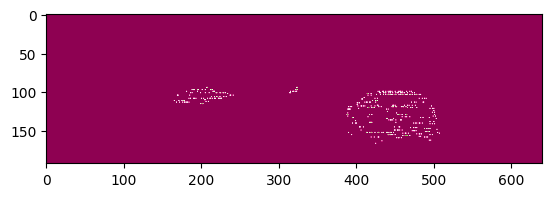

In [5]:

# 保存处理后的图像
plt.figure("class")
plt.imshow(img, cmap='PiYG')
plt.show()

In [6]:
mu = np.mean(img, axis=0)
sigma = np.std(img, axis=0)
std=(img-mu)/sigma
std[np.isnan(std)] = 0
std=(std+1)*10
unique_vals = np.unique(std)
print(unique_vals)

[  8.20394698   8.36482515   8.54135009   8.54135009   8.74011842
   8.74012152   8.97402165   8.97402165   8.97402444   8.97402446
   8.97403286   9.27642539   9.27642539   9.27642539  10.
  65.67764363  71.15553941  78.556546    78.556546    89.24694427
  89.37253933  89.62314438 107.00877183 107.23808693 107.23915478
 107.46794345 107.46794345 107.46794345 107.46794345 107.46794345
 107.6962019  107.69726479 107.92498435 148.20274961 148.20274961
 148.20274961 148.20274961 148.20274961]


/tmp/ipykernel_559542/2097280969.py:3: RuntimeWarning: invalid value encountered in divide
  std=(img-mu)/sigma


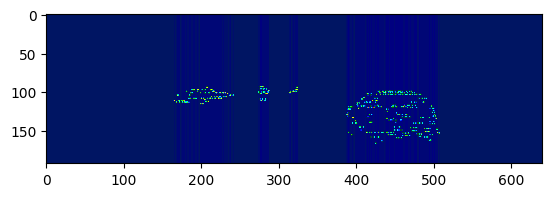

In [7]:

# 保存处理后的图像
plt.figure("class")
plt.imshow(std, cmap='gist_ncar')
plt.show()

In [8]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [9]:
class SemKITTI_DVPS_Dataset(Dataset):
    def __init__(self, root, split='train',
                 image_transform=None,
                 GT_transform=None,
                 ):
        """
        Args:
            root (str): 数据集根目录，例如 '/path/to/dataset'
            split (str): 数据集的划分，'train' 或 'val'
            image_transform: 对 RGB 图像进行预处理的 transform
            depth_transform: 对深度图进行预处理的 transform
            seg_transform: 对语义分割标签进行预处理的 transform
            inst_transform: 对实例分割标签进行预处理的 transform
        """
        self.root = root
        self.split = split
        self.image_transform = image_transform
        self.GT_transform = GT_transform
        
        self.samples = []  # 每个元素为一个字典，包含该样本的各个图片路径
        split_dir = os.path.join(root, split)
        all_files = sorted(os.listdir(split_dir))
        
        # 按照样本前缀分组，假设前缀为前4个字符（例如 "0001"）
        sample_dict = {}
        for file in all_files:
            # 去除空格、统一小写
            file_name_element = file.split("_")#[00000_00000_depth_718]
            scene=file_name_element[0]#标记场景
            frame=file_name_element[1]#标记帧
            
            if scene != "000000":#只加载第一组
                continue
                
            if scene not in sample_dict:
                sample_dict[scene] = {}
                if frame not in sample_dict[scene]:
                    sample_dict[scene][frame]={}
                else:
                    pass
            else:
                if frame not in sample_dict[scene]:
                    sample_dict[scene][frame]={}
                else:
                    pass
            
            # 根据文件名中包含的关键字确定图片类型
            if 'depth' in file_name_element:
                sample_dict[scene][frame]['depth'] = os.path.join(split_dir, file)
                sample_dict[scene][frame]['focal'] = file_name_element[3].split(".")[0]
            else:
                pass
            
            if 'class.png' in file_name_element:
                sample_dict[scene][frame]['class'] = os.path.join(split_dir, file)
                
            else:
                pass
            
            if 'instance.png' in file_name_element:
                sample_dict[scene][frame]['instance'] = os.path.join(split_dir, file)
                
            else:
                pass
            
            if 'leftImg8bit.png' in file_name_element:
                sample_dict[scene][frame]['Img'] = os.path.join(split_dir, file)
                
            else:
                pass
        
        # 过滤出包含所有四种图片的样本frame
        for scene, frames in sample_dict.items():
            for frame, files in frames.items():
                if all(key in files for key in ['depth', 'Img', 'class', 'instance']):
                    self.samples.append(files)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        # 加载 RGB 图像，并转换为 RGB 格式
        image = Image.open(sample['Img']).convert('RGB')
        # 加载深度图（深度图可能为单通道图像）
        depth = Image.open(sample['depth'])
        # 加载语义分割标签，通常为单通道标签图
        seg = Image.open(sample['class'])
        # 加载实例分割标签
        inst = Image.open(sample['instance'])
        
        # 对图像应用预处理 transform
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        
        depth = GT_transforms(depth)
        
        seg = GT_transforms(seg)
            
        inst = GT_transforms(inst)
        
        return image, depth, seg, inst

In [10]:
if __name__ == '__main__':
    dataset_root = '/root/autodl-tmp/video_sequence'  # 修改为你的数据集根目录

    # 定义图像预处理
    image_transforms = transforms.Compose([
        transforms.Resize((192, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    GT_transforms = transforms.Compose([
        transforms.Resize((192, 640),interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
    ])
    # 可根据需要为深度图单独定义 transform，例如仅做 resize 和 ToTensor
    # 对于 segment 和 instance，由于它们是标签，通常不希望有归一化操作，可以直接转换为 Tensor
    # 这里我们在 __getitem__ 中已处理

    # 构造训练集
    train_dataset = SemKITTI_DVPS_Dataset(root=dataset_root,
                                          split='train',
                                          image_transform=image_transforms,
                                             GT_transform=GT_transforms)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4)

    # 测试加载数据
    for images, depths, segments, instances in train_loader:
        print("RGB 图像 batch 尺寸:", images.shape)       # 例如 [4, 3, 256, 512]
        print("深度图 batch 尺寸:", depths.shape)          # 例如 [4, 1, 256, 512]
        print("语义标签 batch 尺寸:", segments.shape)       # 例如 [4, 256, 512]
        print("实例标签 batch 尺寸:", instances.shape)      # 例如 [4, 256, 512]
        break


RGB 图像 batch 尺寸: torch.Size([2, 3, 192, 640])
深度图 batch 尺寸: torch.Size([2, 1, 192, 640])
语义标签 batch 尺寸: torch.Size([2, 1, 192, 640])
实例标签 batch 尺寸: torch.Size([2, 1, 192, 640])


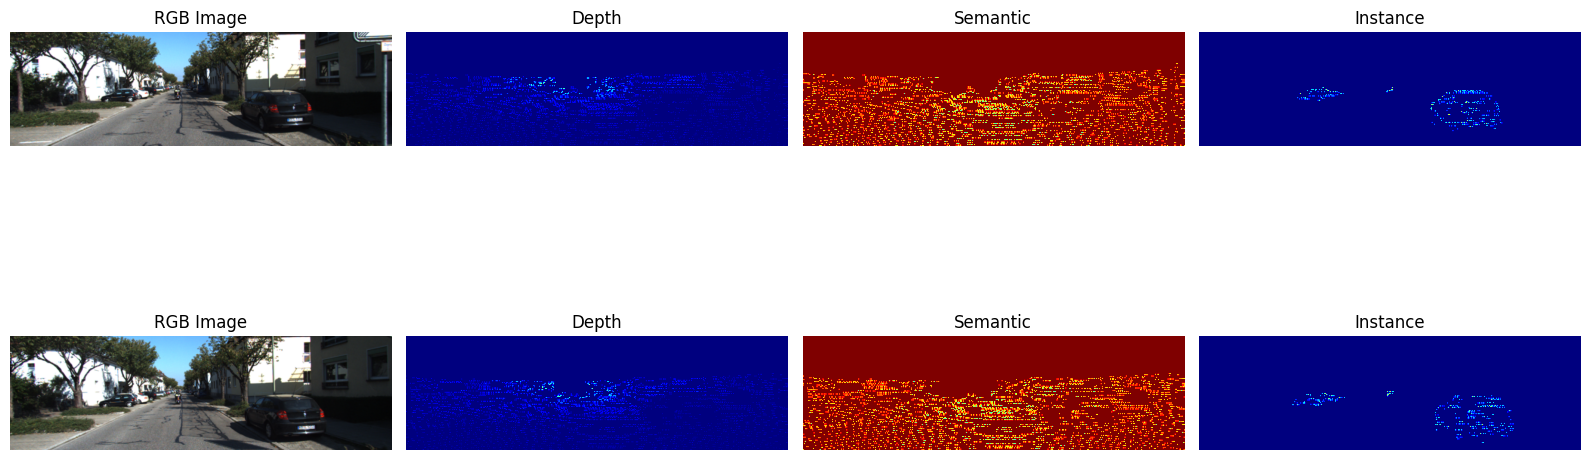

In [11]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# 假设 train_loader 已经定义并加载了数据，返回 (RGB, depth, seg, instance)
data_iter = iter(train_loader)
images, depths, segments, instances = next(data_iter)

# 如果使用了 ImageNet 的归一化，则需要反归一化处理 RGB 图像以便显示
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images * std + mean  # 反归一化，保持 [0,1] 范围

batch_size = images.shape[0]

# 创建图像网格，每行显示一个样本的四个图像
fig, axes = plt.subplots(batch_size, 4, figsize=(16, 4 * batch_size))

# 如果 batch_size 为 1 时，axes 可能是一维数组，统一变为二维数组
if batch_size == 1:
    axes = axes.reshape(1, -1)

for i in range(batch_size):
    # RGB图像：Tensor shape [3, H, W] -> numpy array [H, W, 3]
    img = images_vis[i].permute(1, 2, 0).cpu().numpy()
    
    # 深度图：假设为单通道图像
    depth = depths[i].squeeze().cpu().numpy()
    
    # 语义标签：如果 shape 为 (1, H, W)，squeeze 至 (H, W)
    seg = segments[i]
    if seg.ndim == 3 and seg.shape[0] == 1:
        seg = seg.squeeze(0)
    seg = seg.cpu().numpy()
    
    # 实例标签：同理处理
    inst = instances[i]
    if inst.ndim == 3 and inst.shape[0] == 1:
        inst = inst.squeeze(0)
    inst = inst.cpu().numpy()

    # 显示 RGB 图像
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("RGB Image")
    axes[i, 0].axis('off')

    # 显示深度图 (灰度图)
    axes[i, 1].imshow(depth, cmap='jet')
    axes[i, 1].set_title("Depth")
    axes[i, 1].axis('off')

    # 显示语义标签
    axes[i, 2].imshow(seg, cmap='jet')
    axes[i, 2].set_title("Semantic")
    axes[i, 2].axis('off')

    # 显示实例标签
    axes[i, 3].imshow(inst, cmap='jet')
    axes[i, 3].set_title("Instance")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

# 确保当前张量已经转移到 GPU 上
images = images.to('cuda')
depths = depths.to('cuda')
segments = segments.to('cuda')
instances = instances.to('cuda')

# 检查当前 GPU 上的内存占用情况（单位为字节）
current_memory = torch.cuda.memory_allocated()
max_memory = torch.cuda.max_memory_allocated()
print(f"当前已分配显存: {current_memory / (1024 ** 2):.2f} MB")
print(f"历史最大显存: {max_memory / (1024 ** 2):.2f} MB")

当前已分配显存: 5.62 MB
历史最大显存: 5.62 MB


In [13]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import random
from collections import defaultdict

from ldmseg.data.util.mask_generator import MaskingGenerator
from ldmseg.utils.utils import color_map
from ldmseg.data.util.mypath import MyPath

class SemKITTI_DVPS_Dataset(Dataset):
    KITTI_CATEGORIES = [
        {"color": [0, 0, 0], "isthing": 0, "id": 0,  "name": "unlabeled"},
        {"color": [0, 0, 0], "isthing": 0, "id": 1,  "name": "outlier"},
        {"color": [0, 0, 142], "isthing": 1, "id": 10, "name": "car"},
        {"color": [119, 11, 32], "isthing": 1, "id": 11, "name": "bicycle"},
        {"color": [0, 0, 230], "isthing": 1, "id": 12, "name": "motorcycle"},
        {"color": [106, 0, 228], "isthing": 1, "id": 13, "name": "truck"},
        {"color": [0, 60, 100], "isthing": 1, "id": 14, "name": "other-vehicle"},
        {"color": [0, 80, 100], "isthing": 1, "id": 15, "name": "person"},
        {"color": [0, 0, 70], "isthing": 1, "id": 16, "name": "bicyclist"},
        {"color": [0, 0, 192], "isthing": 1, "id": 17, "name": "motorcyclist"},
        {"color": [250, 170, 30], "isthing": 0, "id": 18, "name": "road"},
        {"color": [100, 170, 30], "isthing": 0, "id": 19, "name": "parking"},
        {"color": [220, 220, 0], "isthing": 0, "id": 20, "name": "sidewalk"},
        {"color": [175, 116, 175], "isthing": 0, "id": 21, "name": "other-ground"},
        {"color": [250, 0, 30], "isthing": 0, "id": 22, "name": "building"},
        {"color": [165, 42, 42], "isthing": 0, "id": 23, "name": "fence"},
        {"color": [255, 77, 255], "isthing": 0, "id": 24, "name": "pole"},
        {"color": [0, 226, 252], "isthing": 0, "id": 25, "name": "traffic sign"},
        {"color": [182, 182, 255], "isthing": 0, "id": 26, "name": "vegetation"},
        {"color": [0, 82, 0], "isthing": 0, "id": 27, "name": "trunk"},
        {"color": [120, 166, 157], "isthing": 0, "id": 28, "name": "terrain"},
        {"color": [110, 76, 0], "isthing": 0, "id": 29, "name": "sky"}
    ]
    KITTI_CATEGORY_NAMES = [cat["name"] for cat in KITTI_CATEGORIES]

    def __init__(self, root,
                 image_transform,
                 GT_transform,
                 split='train'):
        """
        Args:
            root (str): 数据集根目录，例如 '/path/to/dataset'
            split (str): 数据集划分，'train' 或 'val'
            image_transform: 对 RGB 图像的 transform
            GT_transform: 对标签图（class、instance等）的 transform（通常采用最近邻插值）
        """
        self.root = root
        self.split = split
        self.image_transform = image_transform
        self.GT_transform = GT_transform
        # 构造样本列表，假定所有样本存放在 root/split 目录下
        self.samples = []
        split_dir = os.path.join(root, split)
        all_files = sorted(os.listdir(split_dir))
        sample_dict = {}
        for file in all_files:
            file_elems = file.split("_")
            # 示例中以 scene 和 frame 来分组，如 "000000_00000_class.png" 等
            scene = file_elems[0]
            frame = file_elems[1]
            if scene != "000000":#只加载第一组
                continue
                
            if scene not in sample_dict:
                sample_dict[scene] = {}
                if frame not in sample_dict[scene]:
                    sample_dict[scene][frame]={}
                else:
                    pass
            else:
                if frame not in sample_dict[scene]:
                    sample_dict[scene][frame]={}
                else:
                    pass
            
            # 根据文件名中包含的关键字确定图片类型
            if 'depth' in file_elems:
                sample_dict[scene][frame]['depth'] = os.path.join(split_dir, file)
                sample_dict[scene][frame]['focal'] = file_elems[3].split(".")[0]
            else:
                pass
            
            if 'class.png' in file_elems:
                sample_dict[scene][frame]['class'] = os.path.join(split_dir, file)
                
            else:
                pass
            
            if 'instance.png' in file_elems:
                sample_dict[scene][frame]['instance'] = os.path.join(split_dir, file)
                
            else:
                pass
            
            if 'leftImg8bit.png' in file_elems:
                sample_dict[scene][frame]['Img'] = os.path.join(split_dir, file)
                
            else:
                pass
        for scene, frames in sample_dict.items():
            for frame, files in frames.items():
                if all(key in files for key in ['depth', 'Img', 'class', 'instance']):
                    self.samples.append(files)
        print("Found {} samples in split {}".format(len(self.samples), split))
        # 这里设置 ignore_label 为 255（与 COCO 模板类似），num_classes 为实际输出类别数，这里假设 KITTI 的 remapped 类别数为 6（包括背景）
        self.ignore_label = 255
        self.num_classes = 6
        # 初始化颜色映射
        self.cmap = color_map()  # 可使用默认或者自定义
        # 初始化 MaskingGenerator
        self.maskgenerator = MaskingGenerator(input_size=(64, 64), mode='random_local')
        # 这里建立一个简单的 meta_data，此处直接建立空字典
        self.meta_data = {}

        # 如果需要 remap 标签，可在后续添加
        self.remap_labels = False
        self.caption_type = 'none'
        self.caption_dropout = 0.0
        # 设置 pixel_threshold 用于过滤较小区域（此处暂不使用）
        if self.split == 'train':
            self.pixel_threshold = 10
        else:
            self.pixel_threshold = 0

    def __len__(self):
        return len(self.samples)

    def get_class_names(self):
        return self.KITTI_CATEGORY_NAMES

    def encode_bitmap(self, x: torch.Tensor, n: int = 11, fill_value: float = 0.5):
        """
        将二维标签图 x (H, W) 转换为 bit 编码表示。
        对于 KITTI，假设需要对语义和 instance 分别编码后拼接为 11 个通道（例如：语义5位 + instance6位）。
        这里提供一个简单实现：将 x 的整数值直接拆分为 n 位二进制表示。
        """
        ignore_mask = x == self.ignore_label
        H, W = x.shape
        bits = []
        for i in range(n):
            bit = ((x >> i) & 1).float()
            bits.append(bit)
        bits = torch.stack(bits, dim=0)  # [n, H, W]
        bits[:, ignore_mask] = fill_value
        return bits, ignore_mask

    def __getitem__(self, idx):
        sample = {}
        sample_paths = self.samples[idx]
        # 加载 RGB 图像
        image = Image.open(sample_paths['Img']).convert('RGB')
        # 加载语义分割标签（class）和实例分割标签（instance），以灰度模式加载
        sem_img = Image.open(sample_paths['class']).convert('L')
        inst_img = Image.open(sample_paths['instance']).convert('L')
        # 加载深度图（如果需要，可加载，否则忽略）
        depth = Image.open(sample_paths['depth'])

        # 对 RGB 图像应用预处理 transform，转换为 tensor
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = T.ToTensor()(image)

        # 对标签图使用 GT_transform（应采用最近邻插值），再转换为 tensor
        if self.GT_transform:
            sem_img = self.GT_transform(sem_img)
            inst_img = self.GT_transform(inst_img)
        else:
            sem_img = T.ToTensor()(sem_img)
            inst_img = T.ToTensor()(inst_img)

        # 将语义标签和实例标签转换为 numpy 数组（假设为单通道）
        sem_np = np.array(sem_img.squeeze(0), dtype=np.uint8)
        inst_np = np.array(inst_img.squeeze(0), dtype=np.uint8)
        # 分别对语义和实例做 bit 编码：语义用5位，实例用6位，最终拼接为11通道 tensor
        sem_bits, _ = self.encode_bitmap(torch.from_numpy(sem_np), n=5, fill_value=0.5)
        inst_bits, _ = self.encode_bitmap(torch.from_numpy(inst_np), n=6, fill_value=0.5)
        image_semseg = torch.cat([sem_bits, inst_bits], dim=0)  # shape: [11, H, W]

        # 将语义标签转换为 PIL 图像，然后转 tensor（或直接跳过PIL转换，根据你的需求，这里转换成 tensor）
        semseg_tensor = T.ToTensor()(Image.fromarray(sem_np))

        # mask 设置为全1的 PIL 图像，再转换为 tensor
        mask_tensor = T.ToTensor()(Image.fromarray(np.ones_like(sem_np, dtype=np.uint8) * 255))

        # 处理 image_id：例如，从文件名取 scene 和 frame 合成
        base_name = os.path.basename(sample_paths['Img'])
        parts = base_name.split('_')
        try:
            scene = int(parts[0])
            frame = int(parts[1])
            image_id = scene * 10000 + frame
        except Exception:
            image_id = base_name  # 若解析失败，直接用文件名

        meta = {
            'im_size': (image.shape[1], image.shape[2]) if isinstance(image, torch.Tensor) else image.size,
            'image_file': sample_paths['Img'],
            'image_id': image_id,
            'segments_info': {}  # 如果有详细 annotations 可填入，否则为空字典
        }
        text = ""  # 此处文本说明为空
        inpainting_mask = self.maskgenerator(t=0.0)
        inpainting_mask = torch.from_numpy(inpainting_mask).bool()

        sample = {
            'image': image,                 # RGB 图像 tensor
            'semseg': semseg_tensor,          # 语义标签 tensor
            'mask': mask_tensor,             # mask tensor
            'image_semseg': image_semseg,    # 11通道 bit 编码 tensor
            'meta': meta,
            'text': text,
            'inpainting_mask': inpainting_mask
        }
        return sample

if __name__ == '__main__':
    # 示例：定义预处理
    dataset_root = '/root/autodl-tmp/video_sequence'  # 修改为你的数据集根目录
    image_transforms = T.Compose([
        T.Resize((192, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    GT_transforms = T.Compose([
        T.Resize((192, 640), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
    ])
    dataset = SemKITTI_DVPS_Dataset(root=dataset_root,
                                    split='train',
                                    image_transform=image_transforms,
                                    GT_transform=GT_transforms)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)
    for sample in dataloader:
        print("image:", sample['image'].shape)
        print("semseg:", sample['semseg'].shape)
        print("mask:", sample['mask'])
        print("image_semseg:", sample['image_semseg'].shape)
        print("meta:", sample['meta'])
        print("text:", sample['text'])
        print("inpainting_mask:", sample['inpainting_mask'].shape)
        break

Found 4541 samples in split train
image: torch.Size([2, 3, 192, 640])
semseg: torch.Size([2, 1, 192, 640])
mask: tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
image_semseg: torch.Size([2, 11, 192, 640])
meta: {'im_size': [tensor([192, 192]), tensor([640, 640])], 'image_file': ['/root/autodl-tmp/video_sequence/train/000000_001734_leftImg8bit.png', '/root/autodl-tmp/video_sequence/train/000000_000919_leftImg8bit.png'], 'image_id': tensor([1734,  919]), 'segments_info': {}}
text: ['', '']
inpainting_mas